# Explore NOAA GEFSv12 Reforecast data
This notebook explores ways to fetch and read the Grib2 format of these files.  My preference is to use xarray but there are some quirks in the data that required non-standard methods of reading.  For example using the automatic filtering function of cfgrib (grib engine in xarray) https://github.com/ecmwf/cfgrib#automatic-filtering

## Data located on amazon aws
* https://noaa-gefs-retrospective.s3.amazonaws.com/index.html

In [1]:
import urllib.request
import requests

In [38]:
# URL of AWS S3 Explorer: https://noaa-gefs-retrospective.s3.amazonaws.com/index.html#GEFSv12/reforecast/2000/2000010200/c00/Days:1-10/
url = 'https://noaa-gefs-retrospective.s3.amazonaws.com/GEFSv12/reforecast/2000/2000010100/c00/Days:1-10/tmin_2m_2000010100_c00.grib2'
# Using urllib
urllib.request.urlretrieve(url, 'urllib_tmin_2m_2000010100_c00.grib2')
# Using requests
r = requests.get(url)
with open('tmin_2m_2000010100_c00.grib2', 'wb') as f:
    f.write(r.content)

In [3]:
print(r.status_code)
print(r.headers['content-type'])
print(r.encoding)

200
binary/octet-stream
None


In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import pygrib

grbs = pygrib.open('tmin_2m_2000010100_c00.grib2')

In [37]:
#print inventory
grbs.seek(0)
for index,g in enumerate(grbs):
#     if index <= 2:
#         print(g)
    print(g.typeOfLevel, g.level, g.name, g.validDate, g.analDate, g.forecastTime, g.hourOfEndOfOverallTimeInterval, g.timeIncrement, g.isHindcast)
print(g.keys())

heightAboveGround 2 Minimum temperature 2000-01-01 00:00:00 2000-01-01 00:00:00 0 3 0 0
heightAboveGround 2 Minimum temperature 2000-01-01 00:00:00 2000-01-01 00:00:00 0 6 0 0
heightAboveGround 2 Minimum temperature 2000-01-01 06:00:00 2000-01-01 00:00:00 6 9 0 0
heightAboveGround 2 Minimum temperature 2000-01-01 06:00:00 2000-01-01 00:00:00 6 12 0 0
heightAboveGround 2 Minimum temperature 2000-01-01 12:00:00 2000-01-01 00:00:00 12 15 0 0
heightAboveGround 2 Minimum temperature 2000-01-01 12:00:00 2000-01-01 00:00:00 12 18 0 0
heightAboveGround 2 Minimum temperature 2000-01-01 18:00:00 2000-01-01 00:00:00 18 21 0 0
heightAboveGround 2 Minimum temperature 2000-01-01 18:00:00 2000-01-01 00:00:00 18 0 0 0
heightAboveGround 2 Minimum temperature 2000-01-02 00:00:00 2000-01-01 00:00:00 24 3 0 0
heightAboveGround 2 Minimum temperature 2000-01-02 00:00:00 2000-01-01 00:00:00 24 6 0 0
heightAboveGround 2 Minimum temperature 2000-01-02 06:00:00 2000-01-01 00:00:00 30 9 0 0
heightAboveGround 2 M

In [22]:
# ds = xr.open_dataset('tmin_2m_2000010100_c00.grib2', engine='cfgrib')#, backend_kwargs={'filter_by_keys':{'fcst time': 3}})
ds = xr.open_dataset('tmin_2m_2000010100_c00.grib2', engine='cfgrib', backend_kwargs={filter_by_keys:{'totalNumber': 2}})

NameError: name 'filter_by_keys' is not defined

In [23]:
import cfgrib
ds = cfgrib.open_datasets('tmin_2m_2000010100_c00.grib2')

Ignoring index file 'tmin_2m_2000010100_c00.grib2.90c91.idx' incompatible with GRIB file


In [25]:
ds[0]

<xarray.Dataset>
Dimensions:            (latitude: 721, longitude: 1440, step: 2)
Coordinates:
    number             int32 0
    time               datetime64[ns] 2000-01-01
  * step               (step) timedelta64[ns] 03:00:00 06:00:00
    heightAboveGround  int32 2
  * latitude           (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude          (longitude) float64 0.0 0.25 0.5 ... 359.2 359.5 359.8
    valid_time         (step) datetime64[ns] ...
Data variables:
    tmin               (step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP

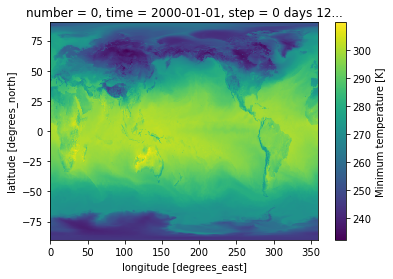

In [34]:
ds[1].tmin.sel(step='12:00:00').plot()

In [21]:
ds = xr.open_dataset('tmin_2m_2000010100_c00.grib2', engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'surface'}})

KeyError: 'paramId'